# Factor analysis

TODO: description

## Configuration

Imports and configure the notebook ...

In [49]:
%load_ext rpy2.ipython
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

import sys
sys.path.append('../')
import spagen

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [50]:
%%R
suppressWarnings(library(ggplot2))
suppressWarnings(library(viridis))

## Data

read dataset

In [5]:
dataset = spagen.data.Dataset('./data/medit/medit.traw',
                              './data/medit/medit.geo', 
                              impute=True,
                              normalize=True, 
                              p_samp=20000
                              )

Lets plot up all the samples locations on a map to visualize what kind of population structure we should expect in the dataset ...

In [15]:
x = dataset.locations.x
labels = dataset.locations.labels
geo_df = pd.DataFrame({'lat': x[:,0], 'lon': x[:,1], 'lab': labels})

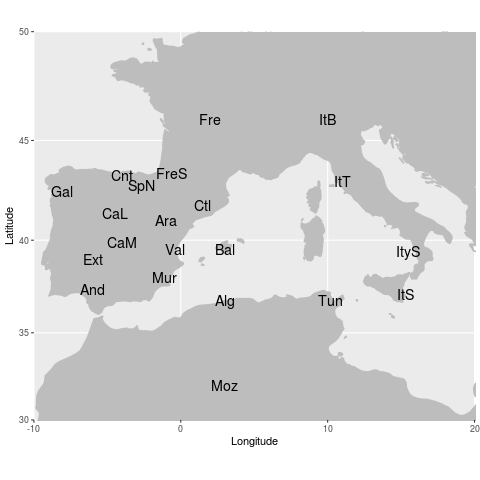

In [48]:
%%R -i geo_df
x <- c(-10.00,  20.00)
y <- c(30.00, 50.0)
p <- ggplot(geo_df %>% distinct(lon, lat, lab), aes(lon, lat, label=lab)) + 
     borders("world", xlim = x, 
             ylim = y,
             fill="#bdbdbd", colour="#bdbdbd") + 
     geom_text(size=5) +
     scale_size_area() + 
     coord_map(xlim = x, ylim = y) +
     xlab('Longitude') + ylab('Latitude') 
p

## Models

### PCA

Here we compare our factor analysis method to PCA ...

In [22]:
pca = PCA(n_components=2)
pca.fit(dataset.genotypes.y)
pcs = pca.components_.T

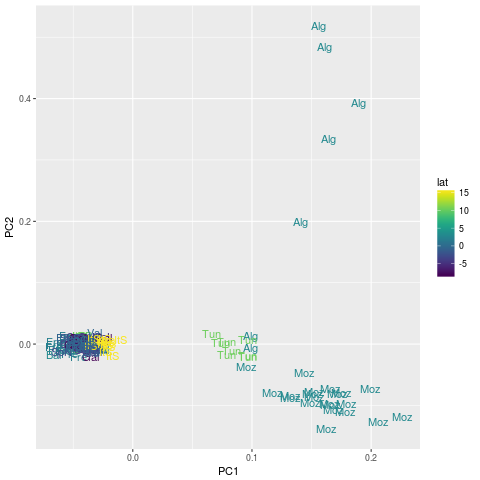

In [23]:
%%R -i pcs,x,labels
pc_df <- as.data.frame(pcs)
colnames(pc_df) <- paste0('PC', 1:2)
pc_df$label <- labels
pc_df$lat <- x[,2]
p_pca <- ggplot(pc_df, aes(x=PC1, y=PC2, label=label, color=lat)) + geom_text() +
         scale_color_viridis()
p_pca

### No spatial random effect / dense loadings

should be similar to pca

In [24]:
%%time
model_ns_dl = spagen.models.FactorAnalysis(dataset, 
                                           k=2, 
                                           spatial_effect=False, 
                                           sparse_loadings=False)
model_ns_dl.fit(n_iter=500)

500/500 [100%] ██████████████████████████████ Elapsed: 38s | Loss: 2219193.000
CPU times: user 4min 1s, sys: 1min 12s, total: 5min 14s
Wall time: 39.2 s


In [25]:
l_hat_ns_dl = model_ns_dl.l_hat

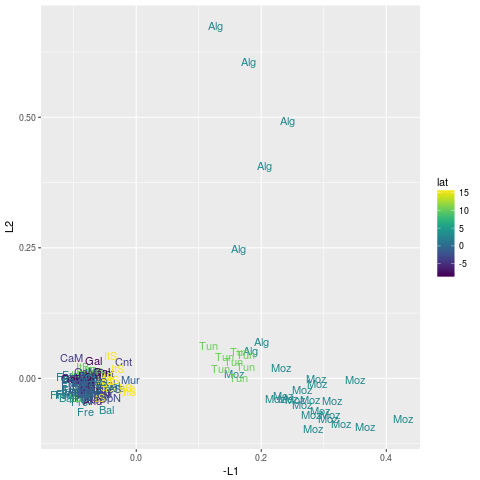

In [32]:
%%R -i l_hat_ns_dl
load_df <- as.data.frame(l_hat_ns_dl)
colnames(load_df) <- paste0('L', 1:2)
load_df$label <- labels
load_df$lat <- x[,2]
p_load <- ggplot(load_df, aes(x=-L1, y=L2, label=label, color=lat)) + geom_text() +
          scale_color_viridis()
p_load

### No spatial random effect / sparse loadings

should be similar to pca / sparse factor model

In [33]:
%%time
model_ns_sl = spagen.models.FactorAnalysis(dataset, 
                                           k=2, 
                                           spatial_effect=False, 
                                           sparse_loadings=True)
model_ns_sl.fit(n_iter=500)

500/500 [100%] ██████████████████████████████ Elapsed: 37s | Loss: 2219739.250
CPU times: user 4min 2s, sys: 1min 18s, total: 5min 20s
Wall time: 37.8 s


In [34]:
l_hat_ns_sl = model_ns_sl.l_hat

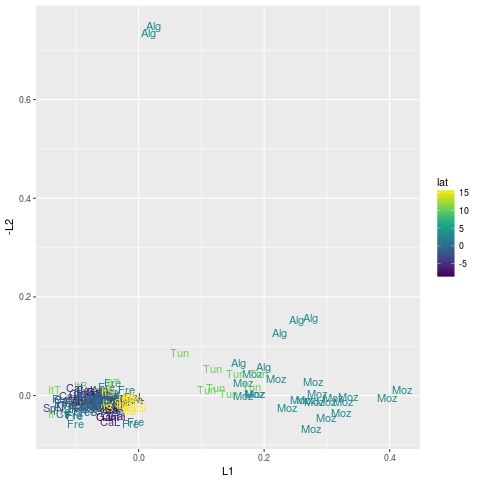

In [41]:
%%R -i l_hat_ns_sl
load_df <- as.data.frame(l_hat_ns_sl)
colnames(load_df) <- paste0('L', 1:2)
load_df$label <- labels
load_df$lat <- x[,2]
p_load <- ggplot(load_df, aes(x=L1, y=-L2, label=label, color=lat)) + geom_text() +
          scale_color_viridis( )
p_load

### Spatial random effect  / dense loadings

should be similar to pca

In [42]:
%%time
model_s_dl = spagen.models.FactorAnalysis(dataset, 
                                          k=2, 
                                          spatial_effect=True, 
                                          sparse_loadings=False)
model_s_dl.fit(n_iter=500)

500/500 [100%] ██████████████████████████████ Elapsed: 37s | Loss: 2219233.250
CPU times: user 3min 58s, sys: 1min 14s, total: 5min 12s
Wall time: 38.3 s


In [43]:
l_hat_s_dl = model_s_dl.l_hat

In [44]:
print('sigma_e = {}\nsigma_s = {}\nalpha = {}'.format(model_s_dl.sigma_e_hat, 
                                                      model_s_dl.sigma_s_hat, 
                                                      model_s_dl.alpha_hat))

sigma_e = 0.9726501703262329
sigma_s = 0.03674459457397461
alpha = 0.1541929543018341


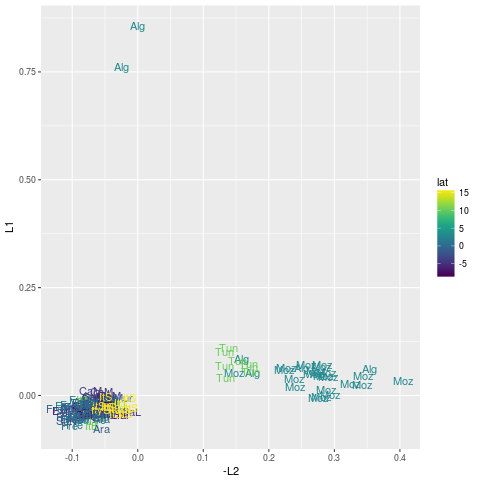

In [46]:
%%R -i l_hat_s_dl
load_df <- as.data.frame(l_hat_s_dl)
colnames(load_df) <- paste0('L', 1:2)
load_df$label <- labels
load_df$lat <- x[,2]
p_load <- ggplot(load_df, aes(x=-L2, y=L1, label=label, color=lat)) + geom_text() +
          scale_color_viridis( )
p_load

### Spatial random effect  / sparse loadings 

In [51]:
%%time
model_s_sl = spagen.models.FactorAnalysis(dataset, 
                                          k=2,
                                          spatial_effect=True, 
                                          sparse_loadings=True)
model_s_sl.fit(n_iter=500)

500/500 [100%] ██████████████████████████████ Elapsed: 37s | Loss: 2220021.750
CPU times: user 3min 58s, sys: 1min 12s, total: 5min 10s
Wall time: 38.3 s


In [48]:
l_hat_s_sl = model_s_sl.l_hat

In [52]:
print('sigma_e = {}\nsigma_s = {}\nalpha = {}'.format(model_s_sl.sigma_e_hat, 
                                                      model_s_sl.sigma_s_hat, 
                                                      model_s_sl.alpha_hat))

sigma_e = 0.9719882011413574
sigma_s = 0.0547989122569561
alpha = 1.234662413597107


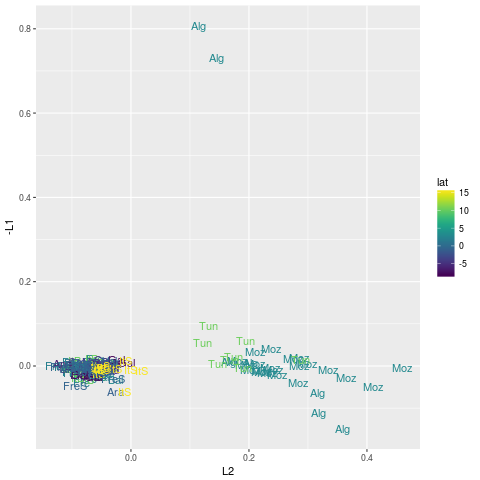

In [55]:
%%R -i l_hat_s_sl
load_df <- as.data.frame(l_hat_s_sl)
colnames(load_df) <- paste0('L', 1:2)
load_df$label <- labels
load_df$lat <- x[,2]
p_load <- ggplot(load_df, aes(x=L2, y=-L1, label=label, color=lat)) + geom_text() +
          scale_color_viridis()
p_load